# Image Captioning
- Generating Captions for Images

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import json
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.utils import to_categorical
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import Add
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [27]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [28]:
captions  = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [29]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [30]:
print(len(captions))

40460


In [31]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


#### Dictionary to Map each Image with the list of captions it has

In [32]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [33]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

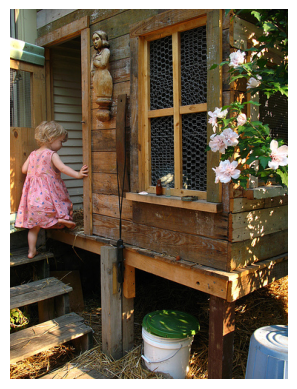

In [34]:
IMG_PATH = "Data/Images/"
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
# img
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()



### Data Cleaning


In [35]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [36]:
clean_text("A cat is sitting over the house # 64 gibghsd")

'cat is sitting over the house gibghsd'

In [37]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [38]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [39]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [40]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [41]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [42]:
print(type(descriptions))

<class 'dict'>


In [43]:
descriptions['1016887272_03199f49c4'][0].split()

['collage', 'of', 'one', 'person', 'climbing', 'cliff']

In [44]:
# We split the words of each sentence for each image, and insert them into a set to form a vocabulary

vocab = set()
for key in descriptions.keys():
    for sentence in descriptions[key]:
        [vocab.update(sentence.split())]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [45]:
# Total No of words across all the sentences

total_words = []

for key in descriptions.keys():
    for sentence in descriptions[key]:
        for i in sentence.split():
            [total_words.append(i)]
    
print("Total Words %d"%len(total_words))

Total Words 373837


### Filter Words from the Vocab according to certain threshold frequncy

In [46]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))
# print(freq_cnt)

8424


In [48]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
# print(sorted_freq_cnt)

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
print(sorted_freq_cnt)

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863), ('dog', 8138), ('with', 7765), ('man', 7275), ('of', 6723), ('two', 5643), ('white', 3959), ('black', 3848), ('boy', 3581), ('are', 3505), ('woman', 3403), ('girl', 3328), ('to', 3176), ('wearing', 3062), ('at', 2916), ('people', 2887), ('water', 2790), ('red', 2691), ('young', 2630), ('brown', 2578), ('an', 2432), ('his', 2357), ('blue', 2279), ('dogs', 2125), ('running', 2073), ('through', 2032), ('playing', 2008), ('while', 1968), ('shirt', 1962), ('down', 1843), ('standing', 1789), ('ball', 1783), ('little', 1768), ('grass', 1622), ('snow', 1547), ('child', 1545), ('person', 1542), ('jumping', 1473), ('over', 1415), ('three', 1389), ('front', 1386), ('sitting', 1368), ('holding', 1324), ('up', 1302), ('field', 1283), ('small', 1278), ('by', 1249), ('large', 1237), ('green', 1234), ('one', 1223), ('group', 1218), ('yellow', 1217), ('her', 1178), ('walking', 1165), ('children', 1156), ('men', 1121), ('into', 

In [49]:
total_words = [x[0] for x in sorted_freq_cnt]
print(len(total_words))

1845


### Prepare Train/Test Data

In [50]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [51]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [52]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [53]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for sentence in descriptions[img_id]:
        sentence_to_append = "startseq "  + sentence + " endseq"
        train_descriptions[img_id].append(sentence_to_append)

In [54]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Step - 1 Image Feature Extraction

In [55]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [56]:
# We will extract the features of the images from the second last layer of the model, rather than the last layer which 
# specifically contains the probabilities of different classes.
model_new = Model(model.input,model.layers[-2].output)

In [57]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [58]:
# img = preprocess_img(IMG_PATH+"".jpg")
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()

## Encoding of the Images

In [59]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    print(feature_vector.shape)
    return feature_vector

In [38]:
encode_image(IMG_PATH+"harsh.jpg")

1/1 [==============================] - 0s 58ms/step
(2048,)


array([0.01138609, 0.5236788 , 1.174738  , ..., 1.3035996 , 0.40688804,
       0.43671122], dtype=float32)

In [35]:
start = time()
encoding_train = {}  

#img_id --> feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 60ms/step
(2048,)
Encoding in Progress Time step 0 
1/1 [==============================] - 0s 61ms/step
(2048,)
1/1 [==============================] - 0s 60ms/step
(2048,)
1/1 [==============================] - 0s 60ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 61ms/step
(2048,)
1/1 [==============================] - 0s 61ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 60ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [=

1/1 [==============================] - 0s 61ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 61ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 62ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 61ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 63ms/step
(2048,)
1/1 [==============================] - 0s 64ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 65ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
Encoding in Progress Time step 1100 
1/1

1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 66ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 67ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
Encoding in Progress Time step 1500 
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 69ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1 [==============================] - 0s 68ms/step
(2048,)
1/1

1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 70ms/step
(2048,)
1/1 [==============================] - 0s 71ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
Encoding in Progress Time step 1900 
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 73ms/step
(2048,)
1/1 [==============================] - 0s 72ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1

1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 74ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 75ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 76ms/step
(2048,)
1/1 [==============================] - 0s 77ms/step
(2048,)
1/1 [==============================] - 0s 78ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 79ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 80ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 85ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 81ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 84ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0s 82ms/step
(2048,)
1/1 [==============================] - 0s 83ms/step
(2048,)
1/1 [==============================] - 0

1/1 [==============================] - 0s 88ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 89ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 90ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0

(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 95ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 91ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [===========================

1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 92ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 93ms/step
(2048,)
1/1 [==============================] - 0s 94ms/step
(2048,)
1/1 [==============================] - 0

(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 99ms/step
(2048,)
1/1 [==============================] - 0s 99ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 99ms/step
(2048,)
1/1 [==============================] - 0s 100ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
Encoding in Progress Time step 3400 
1/1 [==============================] - 0s 100ms/step
(2048,)
1/1 [==============================] - 0s 99ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 97ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(2048,)
1/1 [==============================] - 0s 98ms/step
(

1/1 [==============================] - 0s 115ms/step
(2048,)
1/1 [==============================] - 0s 108ms/step
(2048,)
1/1 [==============================] - 0s 107ms/step
(2048,)
1/1 [==============================] - 0s 105ms/step
(2048,)
1/1 [==============================] - 0s 107ms/step
(2048,)
1/1 [==============================] - 0s 107ms/step
(2048,)
1/1 [==============================] - 0s 117ms/step
(2048,)
1/1 [==============================] - 0s 111ms/step
(2048,)
1/1 [==============================] - 0s 112ms/step
(2048,)
1/1 [==============================] - 0s 105ms/step
(2048,)
1/1 [==============================] - 0s 104ms/step
(2048,)
1/1 [==============================] - 0s 104ms/step
(2048,)
1/1 [==============================] - 0s 103ms/step
(2048,)
1/1 [==============================] - 0s 102ms/step
(2048,)
1/1 [==============================] - 0s 104ms/step
(2048,)
1/1 [==============================] - 0s 104ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 117ms/step
(2048,)
1/1 [==============================] - 0s 116ms/step
(2048,)
1/1 [==============================] - 0s 117ms/step
(2048,)
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 117ms/step
(2048,)
1/1 [==============================] - 0s 117ms/step
(2048,)
1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 116ms/step
(2048,)
1/1 [==============================] - 0s 116ms/step
(2048,)
1/1 [==============================] - 0s 117ms/step
(2048,)
1/1 [==============================] - 0s 115ms/step
(2048,)
1/1 [==============================] - 0s 111ms/step
(2048,)
1/1 [==============================] - 0s 120ms/step
(2048,)
1/1 [==============================] - 0s 113ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 118ms/step
(2048,)
1/1 [==============================] - 0s 120ms/step
(2048,)
Encoding in Progress Time step 4200 
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 121ms/step
(2048,)
1/1 [==============================] - 0s 119ms/step
(2048,)
1/1 [==============================] - 0s 120ms/step
(2048,)
1/1 [==============================] - 0s 120ms/

1/1 [==============================] - 0s 122ms/step
(2048,)
1/1 [==============================] - 0s 124ms/step
(2048,)
1/1 [==============================] - 0s 127ms/step
(2048,)
1/1 [==============================] - 0s 123ms/step
(2048,)
1/1 [==============================] - 0s 123ms/step
(2048,)
1/1 [==============================] - 0s 123ms/step
(2048,)
1/1 [==============================] - 0s 125ms/step
(2048,)
1/1 [==============================] - 0s 125ms/step
(2048,)
1/1 [==============================] - 0s 125ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 132ms/step
(2048,)
1/1 [==============================] - 0s 132ms/step
(2048,)
1/1 [==============================] - 0s 135ms/step
(2048,)
1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [==============================] - 0s 123ms/step
(2048,)
1/1 [==============================] - 0s 124ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 128ms/step
(2048,)
1/1 [==============================] - 0s 130ms/step
(2048,)
1/1 [==============================] - 0s 132ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 132ms/step
(2048,)
1/1 [==============================] - 0s 131ms/step
(2048,)
1/1 [==============================] - 0s 130ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 131ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [==============================] - 0s 131ms/step
(2048,)
1/1 [==============================] - 0s 131ms/step
(2048,)
1/1 [==============================] - 0s 133ms/step
(2048,)
1/1 [==============================] - 0s 129ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 137ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 138ms/step
(2048,)
1/1 [==============================] - 0s 141ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
1/1 [==============================] - 0s 140ms/step
(2048,)
1/1 [==============================] - 0s 139ms/step
(2048,)
Encoding in Progress Time step 5000 
1/1 [==============================] - 0s 138ms/step
(2048,)
1/1 [==============================] - 0s 145ms/step
(2048,)
1/1 [==============================] - 0s 163ms/

1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 146ms/step
(2048,)
1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 146ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [==============================] - 0s 146ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 146ms/step
(2048,)
1/1 [==============================] - 0s 147ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 157ms/step
(2048,)
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 159ms/step
(2048,)
1/1 [==============================] - 0s 155ms/step
(2048,)
1/1 [==============================] - 0s 157ms/step
(2048,)
1/1 [==============================] - 0s 155ms/step
(2048,)
1/1 [==============================] - 0s 155ms/step
(2048,)
1/1 [==============================] - 0s 154ms/step
(2048,)
1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 149ms/step
(2048,)
1/1 [==============================] - 0s 151ms/step
(2048,)
1/1 [==============================] - 0s 151ms/step
(2048,)
1/1 [==============================] - 0s 153ms/step
(2048,)
1/1 [==============================] - 0s 151ms/step
(2048,)
1/1 [==============================] - 0s 148ms/step
(2048,)
1/1 [==============================] - 0s 152ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 158ms/step
(2048,)
1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 159ms/step
(2048,)
1/1 [==============================] - 0s 155ms/step
(2048,)
1/1 [==============================] - 0s 158ms/step
(2048,)
1/1 [==============================] - 0s 158ms/step
(2048,)
1/1 [==============================] - 0s 157ms/step
(2048,)
1/1 [==============================] - 0s 159ms/step
(2048,)
1/1 [==============================] - 0s 159ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 158ms/step
(2048,)
1/1 [==============================] - 0s 157ms/step
(2048,)
1/1 [==============================] - 0s 159ms/step
(2048,)
Encoding in Progress Time step 5800 
1/1 [==============================] - 0s 164ms/

In [36]:
os.makedirs("../saved", exist_ok=True)

In [37]:
# Store everything to the disk 
with open("../saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [38]:
start = time()
encoding_test = {}

#img_id --> feature_vector extracted from Resnet Image
for i,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if i%100==0:
        print("Test Encoding in Progress Time step %d "%i)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

1/1 [==============================] - 0s 161ms/step
(2048,)
Test Encoding in Progress Time step 0 
1/1 [==============================] - 0s 169ms/step
(2048,)
1/1 [==============================] - 0s 160ms/step
(2048,)
1/1 [==============================] - 0s 166ms/step
(2048,)
1/1 [==============================] - 0s 197ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 163ms/step
(2048,)
1/1 [==============================] - 0s 164ms/step
(2048,)
1/1 [==============================] - 0s 165ms/step
(2048,)
1/1 [==============================] - 0s 163ms/step
(2048,)
1/1 [==============================] - 0s 165ms/step
(2048,)
1/1 [==============================] - 0s 162ms/step
(2048,)
1/1 [==============================] - 0s 162ms/step
(2048,)
1/1 [==============================] - 0s 161ms/step
(2048,)
1/1 [==============================] - 0s 162ms/step
(2048,)
1/1 [==============================] - 0s 162m

1/1 [==============================] - 0s 170ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 178ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [==============================] - 0s 179ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [==============================] - 0s 178ms/step
(2048,)
1/1 [==============================] - 0s 175ms/step
(2048,)
1/1 [==============================] - 0s 176ms/step
(2048,)
1/1 [==============================] - 0s 179ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [==============================] - 0s 178ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [==============================] - 0s 177ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
Test Encoding in Progress Time step 400 
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 185ms/step
(2048,)
1/1 [==============================] - 0s 184ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 183ms/step
(2048,)
1/1 [==============================] - 0s 182ms/step
(2048,)
1/1 [==============================] - 0s 18

1/1 [==============================] - 0s 193ms/step
(2048,)
1/1 [==============================] - 0s 192ms/step
(2048,)
1/1 [==============================] - 0s 191ms/step
(2048,)
1/1 [==============================] - 0s 193ms/step
(2048,)
1/1 [==============================] - 0s 191ms/step
(2048,)
1/1 [==============================] - 0s 190ms/step
(2048,)
1/1 [==============================] - 0s 191ms/step
(2048,)
1/1 [==============================] - 0s 192ms/step
(2048,)
1/1 [==============================] - 0s 191ms/step
(2048,)
1/1 [==============================] - 0s 192ms/step
(2048,)
1/1 [==============================] - 0s 193ms/step
(2048,)
1/1 [==============================] - 0s 205ms/step
(2048,)
1/1 [==============================] - 0s 190ms/step
(2048,)
1/1 [==============================] - 0s 190ms/step
(2048,)
1/1 [==============================] - 0s 191ms/step
(2048,)
1/1 [==============================] - 0s 190ms/step
(2048,)
1/1 [===================

1/1 [==============================] - 0s 200ms/step
(2048,)
1/1 [==============================] - 0s 202ms/step
(2048,)
1/1 [==============================] - 0s 202ms/step
(2048,)
Test Encoding in Progress Time step 800 
1/1 [==============================] - 0s 234ms/step
(2048,)
1/1 [==============================] - 0s 198ms/step
(2048,)
1/1 [==============================] - 0s 200ms/step
(2048,)
1/1 [==============================] - 0s 204ms/step
(2048,)
1/1 [==============================] - 0s 202ms/step
(2048,)
1/1 [==============================] - 0s 202ms/step
(2048,)
1/1 [==============================] - 0s 201ms/step
(2048,)
1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 201ms/step
(2048,)
1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 203ms/step
(2048,)
1/1 [==============================] - 0s 20

1/1 [==============================] - 0s 206ms/step
(2048,)
1/1 [==============================] - 0s 206ms/step
(2048,)
1/1 [==============================] - 0s 207ms/step
(2048,)
1/1 [==============================] - 0s 210ms/step
(2048,)
1/1 [==============================] - 0s 205ms/step
(2048,)
1/1 [==============================] - 0s 206ms/step
(2048,)
1/1 [==============================] - 0s 206ms/step
(2048,)
1/1 [==============================] - 0s 207ms/step
(2048,)
1/1 [==============================] - 0s 207ms/step
(2048,)
1/1 [==============================] - 0s 205ms/step
(2048,)
1/1 [==============================] - 0s 206ms/step
(2048,)
1/1 [==============================] - 0s 205ms/step
(2048,)
1/1 [==============================] - 0s 208ms/step
(2048,)
1/1 [==============================] - 0s 208ms/step
(2048,)
1/1 [==============================] - 0s 245ms/step
(2048,)
1/1 [==============================] - 0s 214ms/step
(2048,)
1/1 [===================

In [39]:
with open("../saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [60]:
# Vocab
len(total_words)

1845

In [61]:
word_to_index = {}
index_to_word = {}

for i,word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [62]:
index_to_word

{1: 'in',
 2: 'the',
 3: 'on',
 4: 'is',
 5: 'and',
 6: 'dog',
 7: 'with',
 8: 'man',
 9: 'of',
 10: 'two',
 11: 'white',
 12: 'black',
 13: 'boy',
 14: 'are',
 15: 'woman',
 16: 'girl',
 17: 'to',
 18: 'wearing',
 19: 'at',
 20: 'people',
 21: 'water',
 22: 'red',
 23: 'young',
 24: 'brown',
 25: 'an',
 26: 'his',
 27: 'blue',
 28: 'dogs',
 29: 'running',
 30: 'through',
 31: 'playing',
 32: 'while',
 33: 'shirt',
 34: 'down',
 35: 'standing',
 36: 'ball',
 37: 'little',
 38: 'grass',
 39: 'snow',
 40: 'child',
 41: 'person',
 42: 'jumping',
 43: 'over',
 44: 'three',
 45: 'front',
 46: 'sitting',
 47: 'holding',
 48: 'up',
 49: 'field',
 50: 'small',
 51: 'by',
 52: 'large',
 53: 'green',
 54: 'one',
 55: 'group',
 56: 'yellow',
 57: 'her',
 58: 'walking',
 59: 'children',
 60: 'men',
 61: 'into',
 62: 'air',
 63: 'beach',
 64: 'near',
 65: 'mouth',
 66: 'jumps',
 67: 'another',
 68: 'for',
 69: 'street',
 70: 'runs',
 71: 'its',
 72: 'from',
 73: 'riding',
 74: 'stands',
 75: 'as',


In [63]:
word_to_index

{'in': 1,
 'the': 2,
 'on': 3,
 'is': 4,
 'and': 5,
 'dog': 6,
 'with': 7,
 'man': 8,
 'of': 9,
 'two': 10,
 'white': 11,
 'black': 12,
 'boy': 13,
 'are': 14,
 'woman': 15,
 'girl': 16,
 'to': 17,
 'wearing': 18,
 'at': 19,
 'people': 20,
 'water': 21,
 'red': 22,
 'young': 23,
 'brown': 24,
 'an': 25,
 'his': 26,
 'blue': 27,
 'dogs': 28,
 'running': 29,
 'through': 30,
 'playing': 31,
 'while': 32,
 'shirt': 33,
 'down': 34,
 'standing': 35,
 'ball': 36,
 'little': 37,
 'grass': 38,
 'snow': 39,
 'child': 40,
 'person': 41,
 'jumping': 42,
 'over': 43,
 'three': 44,
 'front': 45,
 'sitting': 46,
 'holding': 47,
 'up': 48,
 'field': 49,
 'small': 50,
 'by': 51,
 'large': 52,
 'green': 53,
 'one': 54,
 'group': 55,
 'yellow': 56,
 'her': 57,
 'walking': 58,
 'children': 59,
 'men': 60,
 'into': 61,
 'air': 62,
 'beach': 63,
 'near': 64,
 'mouth': 65,
 'jumps': 66,
 'another': 67,
 'for': 68,
 'street': 69,
 'runs': 70,
 'its': 71,
 'from': 72,
 'riding': 73,
 'stands': 74,
 'as': 75,


In [64]:
print(len(index_to_word))

1845


In [65]:
# Two special words
index_to_word[1846] = 'startseq'
word_to_index['startseq'] = 1846

index_to_word[1847] = 'endseq'
word_to_index['endseq'] = 1847

vocab_size = len(word_to_index) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [66]:
max_len = 0 
for key in train_descriptions.keys():
    for captions in train_descriptions[key]:
        max_len = max(max_len,len(captions.split()))
        
print(max_len)

35


## Word Embeddings 

In [67]:
f = open("../saved/glove.6B.50d.txt",encoding='utf8')

In [68]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [69]:
f.close()

In [70]:
embedding_index['queen']

array([ 0.37854  ,  1.8233   , -1.2648   , -0.1043   ,  0.35829  ,
        0.60029  , -0.17538  ,  0.83767  , -0.056798 , -0.75795  ,
        0.22681  ,  0.98587  ,  0.60587  , -0.31419  ,  0.28877  ,
        0.56013  , -0.77456  ,  0.071421 , -0.5741   ,  0.21342  ,
        0.57674  ,  0.3868   , -0.12574  ,  0.28012  ,  0.28135  ,
       -1.8053   , -1.0421   , -0.19255  , -0.55375  , -0.054526 ,
        1.5574   ,  0.39296  , -0.2475   ,  0.34251  ,  0.45365  ,
        0.16237  ,  0.52464  , -0.070272 , -0.83744  , -1.0326   ,
        0.45946  ,  0.25302  , -0.17837  , -0.73398  , -0.20025  ,
        0.2347   , -0.56095  , -2.2839   ,  0.0092753, -0.60284  ])

In [71]:
embedding_index['king']-embedding_index['man']-embedding_index['woman']

array([ 0.780426  , -0.39227   ,  0.15917   ,  0.926999  , -2.58574   ,
       -1.88333   ,  0.71755   , -0.35753   , -0.86766   , -0.16606   ,
       -0.170726  ,  2.05762   ,  0.313671  , -2.09354   , -0.7529    ,
        1.66085   ,  0.27154   , -1.39277   ,  0.165826  ,  0.18749   ,
        1.56314   , -3.18425   , -0.081348  , -1.29489   , -0.67224   ,
        3.2603    ,  0.3999    , -1.82819   , -0.92989   ,  0.9788    ,
       -2.9117    ,  0.57753   , -0.17318   ,  0.45885714,  0.0102    ,
       -0.240283  ,  0.24166   , -0.28022   , -1.42015   ,  1.57142   ,
        0.739024  ,  0.12178   , -1.44226   , -0.531925  , -1.3692    ,
        2.16659   , -0.19935   ,  0.68245   , -1.66325   , -0.2885    ])

In [72]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,index in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[index] = embedding_vector
            
    return matrix

In [73]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

#### Model Architecture

In [74]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [75]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [76]:
decoder1 = Add()([inp_img2, inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [78]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [79]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## Data Loader

In [96]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, y = [], [], []  # Lists to hold images, sequences, and labels
    n = 0  # Counter for the number of examples in the current batch
    
    while True:  # Infinite loop to continuously yield data
        for key, desc_list in train_descriptions.items():
            n += 1  # Increment example counter
            
            photo = encoding_train[key]  # Get the encoded image features for the current image
            
            for desc in desc_list:
                # Convert the caption into a sequence of word indices
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                # Generate input-output pairs for the sequence
                for i in range(1, len(seq)):
                    xi = seq[0:i]  # Input sequence (all words up to the current word)
                    yi = seq[i]    # Output word (the current word)
                    
                    # Pad the input sequence to the maximum length
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    
                    # One-hot encode the output word
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    # Append the data to the lists
                    X1.append(photo)  # Append the image features
                    X2.append(xi)     # Append the padded input sequence
                    y.append(yi)      # Append the one-hot encoded output word
                    
                # Yield a batch of data once we reach the specified batch size
                if n == batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]  # Return the batch
                    X1, X2, y = [], [], []  # Reset the lists for the next batch
                    n = 0  # Reset the counter

### Training of Model

In [81]:
with open("../saved/encoded_train_features.pkl", "rb") as f:
    encoding_train = pickle.load(f)

In [82]:
with open("../saved/encoded_test_features.pkl", "rb") as f:
    encoding_test = pickle.load(f)

In [83]:
len(train_descriptions)

6000

In [85]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [90]:
print('2513260012_03d33305cf' in encoding_train)

True


In [94]:
encoding_train

{'2513260012_03d33305cf': array([0.34707993, 0.5115914 , 0.08728833, ..., 1.1897298 , 0.04043846,
        0.15271074], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00307796, 0.09360031, ..., 0.43103382, 0.37985328,
        0.9165756 ], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.76744604, 0.5342262 , 0.3832519 , ..., 0.02098647, 0.18429348,
        0.0427001 ], dtype=float32),
 '488416045_1c6d903fe0': array([6.2481081e-01, 3.2965478e-01, 1.7820086e-04, ..., 1.2753806e+00,
        4.6392545e-01, 4.9036080e-01], dtype=float32),
 '2644326817_8f45080b87': array([0.11555298, 0.65965444, 0.05323303, ..., 0.14397335, 1.0179377 ,
        0.00556594], dtype=float32),
 '218342358_1755a9cce1': array([1.7061832 , 0.4051477 , 0.35206553, ..., 0.2940891 , 0.04833033,
        0.04654424], dtype=float32),
 '2501968935_02f2cd8079': array([0.10608275, 1.4420811 , 0.04447005, ..., 0.20587164, 0.6978758 ,
        1.5904322 ], dtype=float32),
 '2699342860_5288e203ea': array([0.4612

In [91]:
train_descriptions

{'2513260012_03d33305cf': ['startseq black dog is running after white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through low lying body of water endseq'],
 '2903617548_d3e38d7f88': ['startseq little baby plays croquet endseq',
  'startseq little girl plays croquet next to truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of car with put and ball endseq',
  'startseq the little boy is playing with croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8': ['startseq brown dog in the snow has something hot pink in its mouth endseq',
  'startseq brown dog in the snow holding pink hat endseq',
  'startseq brown dog is holding pink shirt in the snow endseq',
  'startseq dog is carrying something pink in its mouth whil

In [97]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_index,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

2000/2000 [==============================] - 461s 230ms/step - loss: 2.4676


In [99]:
model = load_model('./model_weights/model_19.h5')

## Predictions

In [100]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = index_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

C:\Users\Sarthak Kumar Singh\AppData\Local\Temp\ipykernel_11376\1042875993.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


1/1 [==============================] - 0s 9ms/step


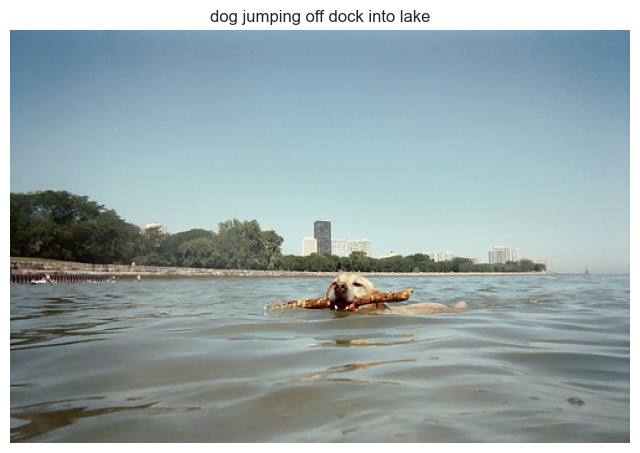

1/1 [==============================] - 0s 7ms/step


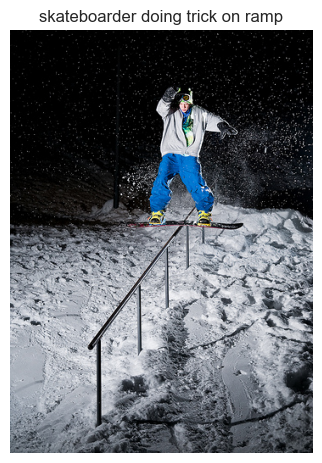

1/1 [==============================] - 0s 18ms/step


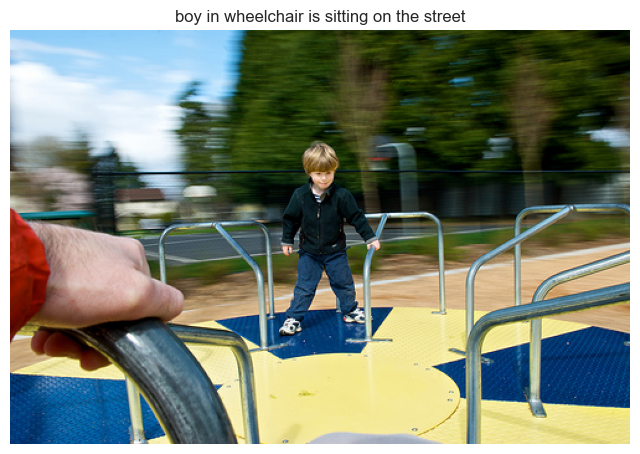

1/1 [==============================] - 0s 20ms/step


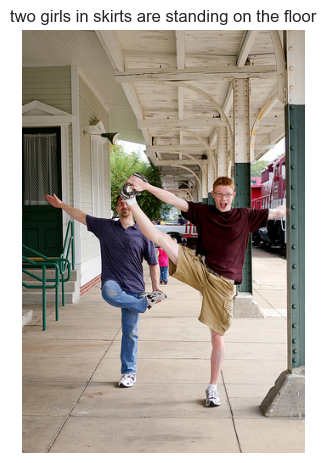

1/1 [==============================] - 0s 13ms/step


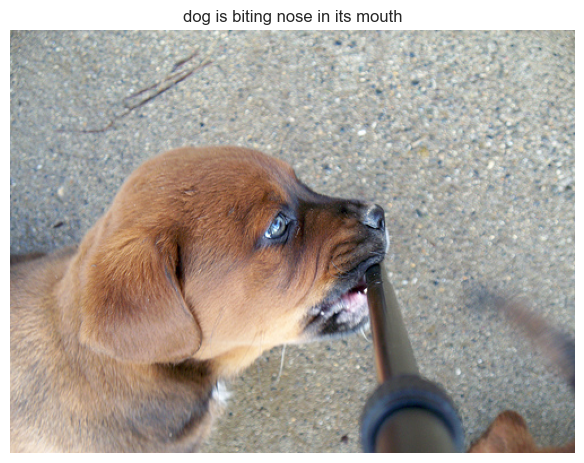

1/1 [==============================] - 0s 18ms/step


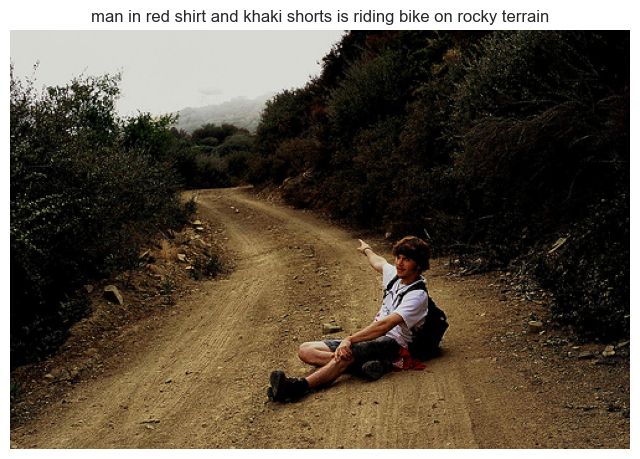

1/1 [==============================] - 0s 8ms/step


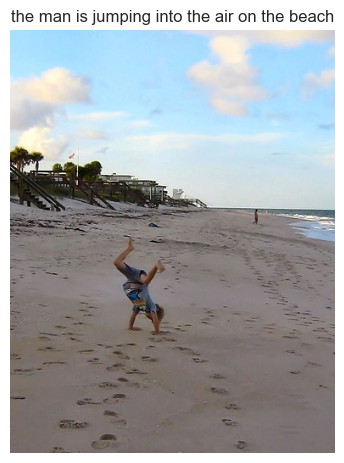

1/1 [==============================] - 0s 9ms/step


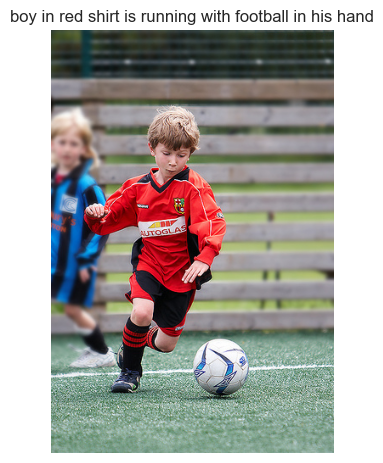

1/1 [==============================] - 0s 8ms/step


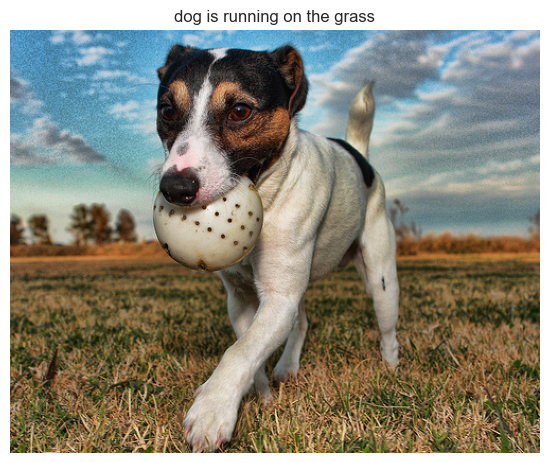

1/1 [==============================] - 0s 8ms/step


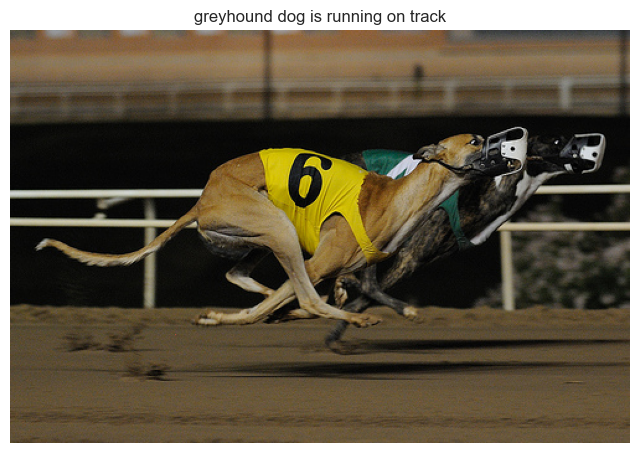

1/1 [==============================] - 0s 13ms/step


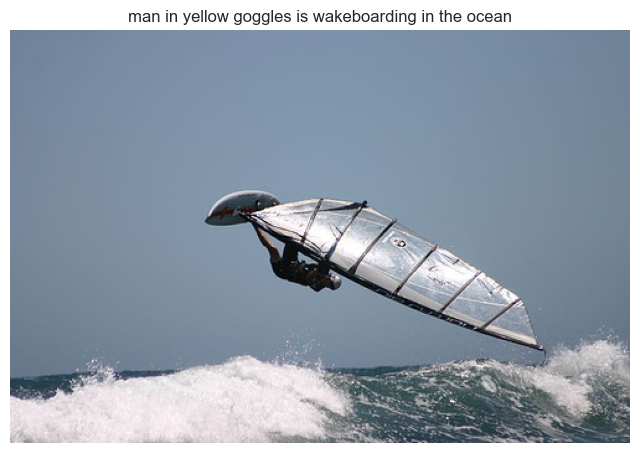

1/1 [==============================] - 0s 6ms/step


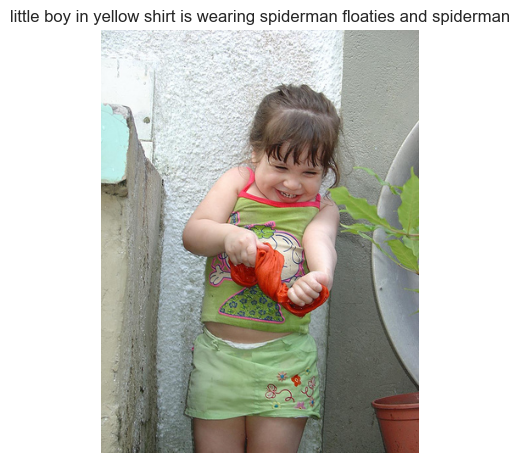

1/1 [==============================] - 0s 5ms/step


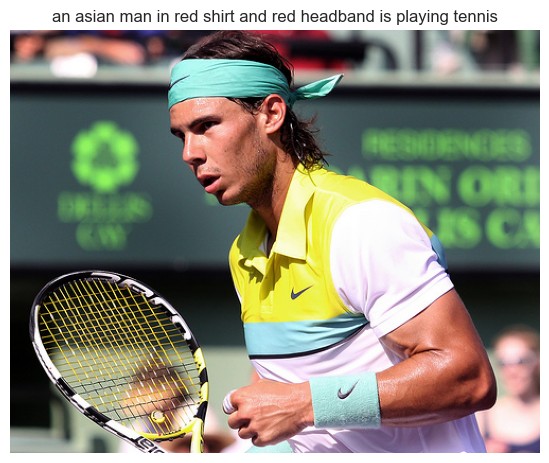

1/1 [==============================] - 0s 8ms/step


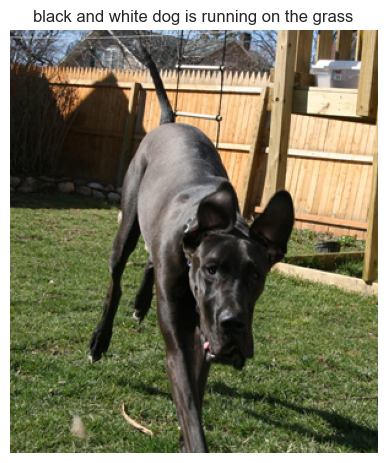

1/1 [==============================] - 0s 8ms/step


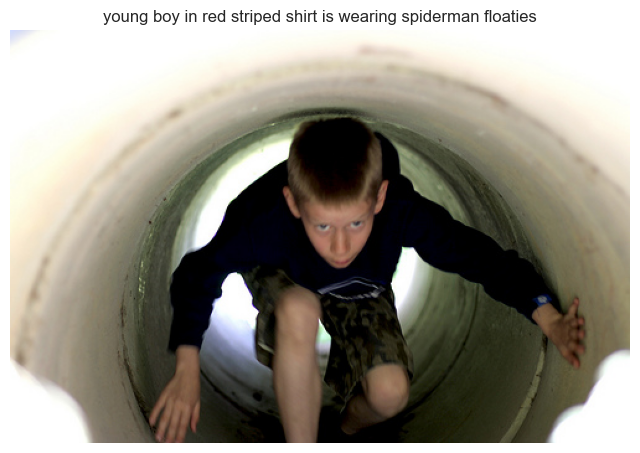

In [101]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
#     print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    